In [1]:
import numpy as np
import mitsuba as mi 
mi.set_variant("cuda_ad_rgb")
from PDE2D import PATH
import os
from PDE2D.utils.sketch import *
root_directory = os.path.join(PATH, "output2D", "optimizations", "variable")
from PDE2D.BoundaryShape import *
from PDE2D.Coefficient import *
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
import matplotlib.ticker as ticker
from PDE2D.utils.common import *

In [2]:
DEFAULT_FONTSIZE = 5.2  # Font size used by captions in ACM format
DEFAULT_FONTSIZE_SMALL = 4.8

MPL_STYLE = {
    "text.usetex": True,
    "text.color": 'black',
    "font.size": DEFAULT_FONTSIZE,
    "axes.titlesize": DEFAULT_FONTSIZE,
    "axes.labelsize": DEFAULT_FONTSIZE_SMALL,
    "xtick.labelsize": DEFAULT_FONTSIZE_SMALL,
    "ytick.labelsize": DEFAULT_FONTSIZE_SMALL,
    "legend.fontsize": DEFAULT_FONTSIZE_SMALL,
    "figure.titlesize": DEFAULT_FONTSIZE,
    "text.latex.preamble": r"""\usepackage{libertine}
                               \usepackage[libertine]{newtxmath}
                               \usepackage{amsmath}
                               \usepackage{amsfonts}
                               \usepackage{bm}
                               \usepackage{bbm}""",
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    'axes.edgecolor':'black',
    'axes.linewidth': 0.4,
    'xtick.major.size': 0.5,
    'xtick.major.width': 0.5,
    'xtick.minor.size': 0.25,
    'xtick.minor.width': 0.5,

    'ytick.major.size': 0.5,
    'ytick.major.width': 0.5,
    'ytick.minor.size': 0.25,
    'ytick.minor.width': 0.5,

    'lines.linewidth': 0.75,
    'patch.linewidth': 0.5,

    'grid.linewidth': 0.5,
}
matplotlib.rcParams.update(MPL_STYLE)

In [3]:
resolution = [512, 512]
bbox=   [[-.91,-.8], [.92,.85]]
cmap_tensor = "viridis"
cmap_boundary = "coolwarm"
cmap_primal_obj = "viridis"
cmap_primal_diff = "coolwarm"
linewidth1 = 1
linewidth2 = 0.5
dist = 0.06
colors = ["black", "darkorange"]
seed = 243
spp_primal = 14
spp_grad = 12
epsilon = 0.01

In [4]:
cmap_source = "Greens"
cmap_screening = "Blues"
cmap_diffusion = "Reds"

In [5]:
conf = 1 
parameter = "source"
bias = 0.0
scale=3.0
screen_s1 = 0.0
folder0 = f"conf{conf}-{parameter}"
folder1 = f"mixed-res32-scale{scale}-bias{bias}-centered-screen{screen_s1}"
folder2 = f"spp{spp_primal}_{spp_grad}-seed{seed}-epsilon{epsilon}"
folder3 = "restensor16-none"
recordpath_s1 = os.path.join(root_directory, folder0, folder1, 
                          folder2, folder3, "npy")
max_range_s1 = [bias, bias+scale * 1.1]


conf = 2 
parameter = "source"
bias = 0.0
scale=3.0
screen_s2 = 10.0
folder0 = f"conf{conf}-{parameter}"
folder1 = f"mixed-res32-scale{scale}-bias{bias}-centered-screen{screen_s2}"
folder2 = f"spp{spp_primal}_{spp_grad}-seed{seed}-epsilon{epsilon}"
folder3 = "restensor16-none"
recordpath_s2 = os.path.join(root_directory, folder0, folder1, 
                          folder2, folder3, "npy")
max_range_s2 = [bias, bias+scale * 1.1]

In [6]:
conf = 1
parameter = "screening"
bias = 1.0
scale=3.0
folder0 = f"conf{conf}-{parameter}"
folder1 = f"mixed-res32-scale{scale}-bias{bias}-centered"
folder2 = f"spp{spp_primal}_{spp_grad}-seed{seed}-epsilon{epsilon}"
folder3 = "restensor16-none"
recordpath_sc1 = os.path.join(root_directory, folder0, folder1, 
                          folder2, folder3, "npy")
max_range_sc1 = [bias, bias + scale * 1.1]

conf = 2
parameter = "screening"
bias = 0.0
scale=3.0
folder0 = f"conf{conf}-{parameter}"
folder1 = f"mixed-res32-scale{scale}-bias{bias}-centered"
folder2 = f"spp{spp_primal}_{spp_grad}-seed{seed}-epsilon{epsilon}"
folder3 = "restensor16-none"
recordpath_sc2 = os.path.join(root_directory, folder0, folder1, 
                          folder2, folder3, "npy")
max_range_sc2 = [bias, bias + scale * 1.1]

In [7]:
conf = 1 
parameter = "diffusion"
bias = 1.0
scale=3.0
screen_d1 = 0.0
folder0 = f"conf{conf}-{parameter}"
folder1 = f"dirichlet-res32-scale{scale}-bias{bias}-centered-screen{screen_d1}"
folder2 = f"spp{spp_primal}_{spp_grad}-seed{seed}-epsilon{epsilon}"
folder3 = "restensor16-none"
recordpath_d1 = os.path.join(root_directory, folder0, folder1, 
                          folder2, folder3, "npy")
max_range_d1 = [bias, bias + scale * 1.1]

conf = 2
parameter = "diffusion"
bias = 1.0
scale=3.0
screen_d2 = 10.0
folder0 = f"conf{conf}-{parameter}"
folder1 = f"dirichlet-res32-scale{scale}-bias{bias}-centered-screen{screen_d2}"
folder2 = f"spp{spp_primal}_{spp_grad}-seed{seed}-epsilon{epsilon}"
folder3 = "restensor16-none"
recordpath_d2 = os.path.join(root_directory, folder0, folder1, 
                          folder2, folder3, "npy")
max_range_d2 = [bias, bias + scale * 1.1]

In [8]:
dirichlet, neumann = load_boundary_data()
shape1 = load_bunny(dirichlet = dirichlet, neumann = neumann, conf=1)
shape2 = load_bunny(dirichlet = dirichlet, neumann = neumann, conf=2)
dirichlet_, neumann_ = load_boundary_data(only_dirichlet=True)
shape3 = load_bunny(dirichlet = dirichlet_, neumann = neumann_, conf=3, all_dirichlet=True)

In [9]:
def get_best_conf(path):
    objective = np.load(os.path.join(path, f"objectives.npy"))
    primal_begin = np.load(os.path.join(path, "primal", f"primal-0.npy"))
    diff = np.sum(np.abs(objective - primal_begin), axis = (1,2))
    ind = np.argsort(diff)
    return diff[ind], ind

In [10]:
def visualize_boundary(ax, shape, bbox, resolution, conf = 4, dist = dist, colorbar =True, cmap = "viridis", lw = linewidth2, neumann = True):
    points = create_image_points(bbox, resolution, spp = 1, centered =True)
    vals_dir = shape.dirichlet[conf].get_value(points)
    vals_neumann = Float(0)
    if neumann:
        vals_neumann = shape.neumann[conf].get_value(points)
    bi = shape.boundary_interaction(points)
    vals = dr.select(bi.is_d, vals_dir, vals_neumann)
    vals = dr.select(bi.d < dist, vals, dr.nan)
    image, _ = create_image_from_result(vals, resolution)
    im = plot_image(image[0], ax, colorbar = colorbar, cmap = cmap)
    shape.sketch(ax, bbox, resolution, lw = lw, colors = colors)
    disable_border(ax)
    return im


In [11]:
def visualize_tensor(ax, shape, image, bbox, resolution, colorbar = False, cmap = "viridis", input_range = [0, 3.2], lw = linewidth1):
    coeff = TextureCoefficient(name = "coeff", bbox = [[-1,-1],[1,1]], tensor_np = image)
    points = create_image_points(bbox, resolution, spp = 4)
    vals = coeff.get_value(points)
    inside_mask = shape.inside_closed_surface_mask(points)
    bi = shape.boundary_interaction(points)
    vals = dr.select(inside_mask | (bi.d < 5e-3), vals, dr.nan)
    image, tensor = create_image_from_result(vals, resolution)
    im = plot_image(image[0], ax, colorbar = colorbar, input_range = input_range, cmap = cmap)
    shape.sketch(ax, bbox, resolution, lw = lw, colors = colors)
    disable_border(ax)
    return im


In [12]:
def visualize_primal(ax, shape, image, bbox, resolution, colorbar = False, cmap = "viridis", input_range = [None, None], lw = linewidth1):
    coeff = TextureCoefficient(name = "coeff", bbox = [[-1,-1],[1,1]], tensor_np = image, interpolation="nearest")
    points = create_image_points(bbox, resolution, spp = 1, centered = True)
    vals = coeff.get_value(points)
    inside_mask = shape.inside_closed_surface_mask(points)
    bi = shape.boundary_interaction(points)
    vals = dr.select(inside_mask | (bi.d < 5e-3), vals, dr.nan)
    image, tensor = create_image_from_result(vals, resolution)
    im = plot_image(image[0], ax, colorbar = colorbar, input_range = input_range, cmap = cmap)
    shape.sketch(ax, bbox, resolution, lw = lw, colors = colors)
    disable_border(ax)
    return im

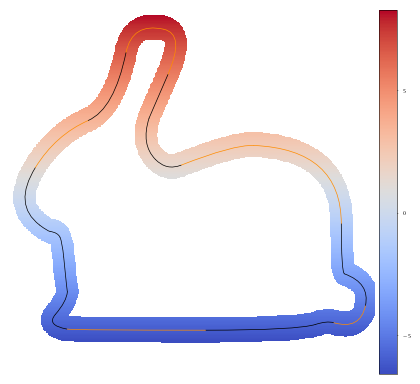

In [13]:
fig, (ax1) = plt.subplots(1,1, figsize = (5,5))
im1 = visualize_boundary(ax1, shape1, bbox, resolution, conf = 32, colorbar = True, cmap = "coolwarm")
disable_border(ax1)


In [14]:

def vis_single_opt(fig, ax, record_path, iters, cbar_offset, pre_cbar_offset, post_cbar_offset, end_offset, cbar_begin, cbar_end, 
                   imsize, conf_boundary, param, cmap_tensor = "Reds", num_ticks = 3, verbose1 = False, verbose2 = False, tensor_range = [None, None]):
    
    title_pad = 6
    neumann = True
    if param == "source":
        shape = shape1
    if param == "screening":
        shape = shape2
    if param == "diffusion":
        shape = shape3
        neumann = False
    num_iter = len(iters)
    num_images = num_iter + 5
    total_cbar_offset = cbar_offset + pre_cbar_offset + post_cbar_offset
    g = gridspec.GridSpecFromSubplotSpec(imsize, imsize * num_images + total_cbar_offset * 4 + end_offset + 1, ax.get_subplotspec(), wspace = None, hspace=None)

    for i, iter in enumerate(iters):
        ax = fig.add_subplot(g[0 : imsize, i * imsize : (i+1) * imsize])
        #image = record[f"{param}.texture.tensor-{iter}"]
        image = np.load(os.path.join(record_path, "tensor", f"{param}.texture.tensor-{iter}.npy"))
        im = visualize_tensor(ax, shape, image, bbox, resolution, colorbar = False, cmap = cmap_tensor, input_range = tensor_range)
        if verbose1:
            text = f"(a{i+1})"
            t = r"$\textbf{" + text + "}$"
            ax.set_title(f"{t} Iter. {iter}", pad = title_pad)
        elif verbose2:
            empty = r"$\textbf{ }$"
            ax.set_title(f"{empty} {empty} {empty} {empty} {empty} Iter. {iter}", pad = 3)
    ax_obj = fig.add_subplot(g[0 : imsize, num_iter * imsize : (num_iter + 1) * imsize])
    #image_obj = record[f"objective-tensor"]
    image_obj = np.load(os.path.join(record_path,f"objective-tensor.npy"))
    visualize_tensor(ax_obj, shape, image_obj, bbox, resolution, colorbar = False, cmap = cmap_tensor, input_range = tensor_range)
    ax_cbar_opt = fig.add_subplot(g[cbar_begin : imsize- cbar_end, (num_iter + 1) * imsize + pre_cbar_offset : 
                                                ((num_iter + 1) * imsize + pre_cbar_offset + cbar_offset)])
    if verbose1:
        ax_obj.set_title(r"$\textbf{(b)}$ Reference", pad = title_pad)
    
    cbar_tensor = plt.colorbar(im, cax = ax_cbar_opt)
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    cbar_tensor.locator = tick_locator
    cbar_tensor.formatter.set_powerlimits((0, 0))
    #cbar_tensor.ax.yaxis.set_offset_position('left') 
    cbar_tensor.update_ticks()

    offset = (num_iter + 1) * imsize + total_cbar_offset
    ax_boundary = fig.add_subplot(g[0 : imsize, offset : offset + imsize])
    if verbose1:
        ax_boundary.set_title(r"$\textbf{(c)}$ Boundary cond.", pad = title_pad)
    im_boundary = visualize_boundary(ax_boundary, shape, bbox, resolution, conf = conf_boundary, colorbar = False, cmap = cmap_boundary, neumann = neumann)

    offset += imsize
    ax_cbar_boundary = fig.add_subplot(g[cbar_begin : imsize-cbar_end, pre_cbar_offset + offset : 
                                                    pre_cbar_offset + offset + cbar_offset])
    cbar_boundary = plt.colorbar(im_boundary, cax = ax_cbar_boundary)
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    cbar_boundary.locator = tick_locator
    cbar_boundary.formatter.set_powerlimits((0, 0))
    #cbar_boundary.ax.yaxis.set_offset_position('left') 
    cbar_boundary.update_ticks()
    offset += total_cbar_offset 

    #primal_objective = record["objectives"][conf_boundary]
    #primal_begin = record["primals-0"][conf_boundary] - primal_objective
    #primal_end = record[f"primals-{iters[-1]}"][conf_boundary] - primal_objective

    primal_objective = np.load(os.path.join(record_path, "objectives.npy")).squeeze()
    primal_begin = np.load(os.path.join(record_path,  "primal", f"primal-0.npy")).squeeze()
    primal_end = np.load(os.path.join(record_path, "primal", f"primal-{iters[-1]}.npy")).squeeze()
    if primal_objective.ndim == 3:
        primal_objective = primal_objective[conf_boundary]
        primal_begin = primal_begin[conf_boundary] - primal_objective 
        primal_end = primal_end[conf_boundary] - primal_objective
    else:
        primal_begin = primal_begin - primal_objective 
        primal_end = primal_end - primal_objective


    ax_primal_objective = fig.add_subplot(g[0 : imsize, offset : offset + imsize])
    im_primal_objective = visualize_primal(ax_primal_objective, shape, primal_objective, bbox, resolution, cmap = cmap_primal_obj, input_range = [None, None])
    if verbose1:
        ax_primal_objective.set_title(r"$\textbf{(d)}$ $u_{\mathrm{ref}}$", pad = title_pad)
    
    offset += imsize
    ax_cbar_primal_obj = fig.add_subplot(g[cbar_begin : imsize-cbar_end, pre_cbar_offset + offset : 
                                                    pre_cbar_offset + offset + cbar_offset])
    cbar_primal_obj = plt.colorbar(im_primal_objective, cax = ax_cbar_primal_obj)
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    cbar_primal_obj.locator = tick_locator
    cbar_primal_obj.formatter.set_powerlimits((0, 0))
    #cbar_primal_obj.ax.yaxis.set_offset_position('left') 
    cbar_primal_obj.update_ticks()
    offset += total_cbar_offset

    maxdiff = max(np.max(primal_begin), np.max(primal_end))
    mindiff = min(np.min(primal_begin), np.min(primal_end))
    max_range = max(maxdiff, -mindiff)
    input_range_diff = [-max_range, max_range]
    
    ax_primal_begin = fig.add_subplot(g[0 : imsize, offset : offset + imsize])
    im_primal_begin = visualize_primal(ax_primal_begin, shape, primal_begin, bbox, resolution, cmap = cmap_primal_diff, input_range = input_range_diff)
    if verbose1:
        ax_primal_begin.set_title(r"$\textbf{(e1)}$ $u_0 - u_{\mathrm{ref}}$", pad = title_pad)
    offset += imsize

    ax_primal_end = fig.add_subplot(g[0 : imsize, offset : offset + imsize])
    im_primal_end = visualize_primal(ax_primal_end, shape, primal_end, bbox, resolution, cmap = cmap_primal_diff, input_range = input_range_diff)
    if verbose1:
        ax_primal_end.set_title(r"$\textbf{(e2)}$ $u_{\mathrm{last}} - u_{\mathrm{ref}}$", pad = title_pad)
    offset += imsize

    ax_cbar_primal = fig.add_subplot(g[cbar_begin : imsize-cbar_end, pre_cbar_offset + offset : 
                                                    pre_cbar_offset + offset + cbar_offset])
    cbar_primal = plt.colorbar(im_primal_begin, cax = ax_cbar_primal)
    tick_locator = ticker.MaxNLocator(nbins=num_ticks)
    cbar_primal.locator = tick_locator
    cbar_primal.formatter.set_powerlimits((0, 0))
    #cbar_primal.ax.yaxis.set_offset_position('left') 
    cbar_primal.update_ticks()

    #offset += total_cbar_offset + end_offset
    #ax_end = fig.add_subplot(g[0 : imsize, offset])
    #disable_border(ax_end)
    #disable_ticks(ax_end)

In [15]:
iter = 4
a = r"$V_{{iter}}$".format(iter=4)

22
22
75
33


GPL Ghostscript 9.55.0: Can't embed the complete font LinBiolinumT as it is too large, embedding a subset.
GPL Ghostscript 9.55.0: Can't embed the complete font LinLibertineT as it is too large, embedding a subset.
GPL Ghostscript 9.55.0: Can't embed the complete font LinBiolinumTB as it is too large, embedding a subset.


'/home/ekrem/repos/MC-PDE3D/figures/opt_coeff_2D/opt_coeff_2D.pdf'

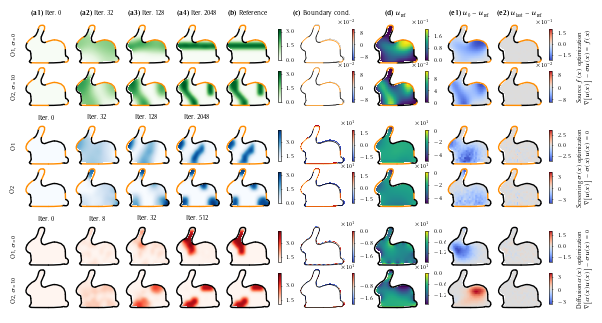

In [16]:
cbar_offset = 2
pre_cbar_offset = 3
post_cbar_offset = 10
total_cbar_offset = cbar_offset + pre_cbar_offset + post_cbar_offset
cbar_begin = 4
cbar_end = 6
imsize = 32
imsize_h = 30
conf_boundary = 0
iters = [0, 16, 64, 512]
num_images = len(iters) + 5
end_offset = 1
scale =(num_images * imsize + 4 * total_cbar_offset + end_offset + 1) / TEXT_WIDTH
fig = plt.figure(figsize = ((num_images * imsize + 4 * total_cbar_offset + end_offset + 1) / scale, 3 * (imsize_h + imsize) / scale))


g = gridspec.GridSpec(3, 1, figure = fig, wspace =0, hspace=0.15)
source_ax = fig.add_subplot(g[0])
screening_ax = fig.add_subplot(g[1])
diffusion_ax = fig.add_subplot(g[2])

eqn_source = r"$\nabla \big[ u(x) \big] - \sigma u(x) = f(x)$"
source_ax.set_ylabel(f"Source $f(x)$ optimization \n {eqn_source}")
eqn_screening = r"$\nabla \big[ u(x) \big] - \sigma(x)u(x) = 0$"
screening_ax.set_ylabel(f"Screening $\sigma(x)$ optimization \n {eqn_screening}")
eqn_diffusion = r"$\nabla \big[ \alpha(x) u(x) \big] - \sigma u(x) = 0$"
diffusion_ax.set_ylabel(f"Diffusion $\\alpha(x)$ optimization \n {eqn_diffusion}")

source_ax.yaxis.set_label_position("right")
screening_ax.yaxis.set_label_position("right")
diffusion_ax.yaxis.set_label_position("right")

disable_border(source_ax)
disable_border(screening_ax)
disable_border(diffusion_ax)
disable_ticks(source_ax)
disable_ticks(screening_ax)
disable_ticks(diffusion_ax)


################## Source #######################################
g_source = gridspec.GridSpecFromSubplotSpec(imsize_h + imsize, 1, source_ax.get_subplotspec(), wspace=0, hspace=0)
conf_boundary = 0
iters = [0, 32, 128, 2048]
source_ax1 = fig.add_subplot(g_source[0 : imsize])
str_s1 = r"O1, $\sigma$"
source_ax1.set_ylabel(f"{str_s1}={int(screen_s1)}")
disable_border(source_ax1)
disable_ticks(source_ax1)
#diff_in, ind = get_best_conf(record_source1)
#conf_boundary = ind[-1]
vis_single_opt(fig, source_ax1, recordpath_s1, iters, cbar_offset, pre_cbar_offset, post_cbar_offset, end_offset, cbar_begin, cbar_end, imsize, 
               conf_boundary, "source", verbose1 = True, tensor_range = max_range_s1, cmap_tensor = cmap_source)

source_ax2 = fig.add_subplot(g_source[imsize_h : imsize + imsize_h])
str_s2 = r"O2, $\sigma$"
source_ax2.set_ylabel(f"{str_s2}={int(screen_s2)}")
disable_border(source_ax2)
disable_ticks(source_ax2)
#diff_in, ind = get_best_conf(record_source2)
#conf_boundary = ind[-1]
vis_single_opt(fig, source_ax2, recordpath_s2, iters, cbar_offset, pre_cbar_offset, post_cbar_offset, end_offset, cbar_begin, cbar_end, imsize, 
               conf_boundary, "source", tensor_range = max_range_s2, cmap_tensor = cmap_source)


################## Screening #######################################
g_screen = gridspec.GridSpecFromSubplotSpec(imsize_h + imsize, 1, screening_ax.get_subplotspec(), wspace=0, hspace=0)

iters = [0, 32, 128, 2048]
screen_ax1 = fig.add_subplot(g_screen[0 : imsize])
screen_ax1.set_ylabel(r"O1")
disable_border(screen_ax1)
disable_ticks(screen_ax1)

diff_in, ind = get_best_conf(recordpath_sc1)
conf_boundary = ind[-1]
print(conf_boundary)
vis_single_opt(fig, screen_ax1, recordpath_sc1, iters, cbar_offset, pre_cbar_offset, post_cbar_offset,end_offset, cbar_begin, cbar_end, imsize, 
               conf_boundary, "screening", verbose2 = True, tensor_range = max_range_sc1, cmap_tensor = cmap_screening)

screen_ax2 = fig.add_subplot(g_screen[imsize_h : imsize + imsize_h])
screen_ax2.set_ylabel(r"O2")
disable_border(screen_ax2)
disable_ticks(screen_ax2)
diff_in, ind = get_best_conf(recordpath_sc2)
conf_boundary = ind[-1]
print(conf_boundary)
vis_single_opt(fig, screen_ax2, recordpath_sc2, iters, cbar_offset, pre_cbar_offset, post_cbar_offset,end_offset, cbar_begin, cbar_end, imsize, 
               conf_boundary, "screening", tensor_range = max_range_sc2, cmap_tensor = cmap_screening)


################## Diffusion #######################################
conf_boundary = 16
g_diffusion = gridspec.GridSpecFromSubplotSpec(imsize_h + imsize, 1, diffusion_ax.get_subplotspec(), wspace=0, hspace=0)

iters = [0, 8, 32, 512]
diffusion_ax1 = fig.add_subplot(g_diffusion[0 : imsize])
str_d1 = r"O1, $\sigma$"
diffusion_ax1.set_ylabel(f"{str_d1}={int(screen_d1)}")
disable_border(diffusion_ax1)
disable_ticks(diffusion_ax1)
diff_in, ind = get_best_conf(recordpath_d1)
conf_boundary = ind[-1]
print(conf_boundary)
vis_single_opt(fig, diffusion_ax1, recordpath_d1, iters, cbar_offset, pre_cbar_offset, post_cbar_offset,end_offset, cbar_begin, cbar_end, imsize, 
               conf_boundary, "diffusion", verbose2 = True, tensor_range = max_range_d1, cmap_tensor = cmap_diffusion)

diffusion_ax2 = fig.add_subplot(g_diffusion[imsize_h : imsize + imsize_h])
str_d2 = r"O2, $\sigma$"
diffusion_ax2.set_ylabel(f"{str_d2}={int(screen_d2)}")
disable_border(diffusion_ax2)
disable_ticks(diffusion_ax2)
diff_in, ind = get_best_conf(recordpath_d2)
conf_boundary = ind[-1]
print(conf_boundary)
vis_single_opt(fig, diffusion_ax2, recordpath_d2, iters, cbar_offset, pre_cbar_offset, post_cbar_offset,end_offset, cbar_begin, cbar_end, imsize, 
               conf_boundary, "diffusion", tensor_range = max_range_d2, cmap_tensor = cmap_diffusion)

save_fig("opt_coeff_2D", os.path.join(PATH, "figures"))
plt.savefig(os.path.join(PATH, "figures", "png", "opt_coeff_2D.png"), bbox_inches='tight', pad_inches=0.04, dpi=1000)
#plt.savefig("opt_coeff_2D.pdf", bbox_inches='tight', pad_inches=0.04, dpi=300)